In [1]:
# Import libraries and data 
import scipy.io as sio
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle
import numpy as np
from scipy.signal import find_peaks
from os.path import dirname, join as pjoin
import datetime
import csv
import math
import Tools.data_processing as dp
import Tools.data_movement as dm 
from Tools.auxiliary_functions import get_candidates, detect_flat_plat, detect_stage_rises

# This preprocessing is not optimized and is very slow
fDOM_raw_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv')
stage_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv')
turb_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv')
stage_data = dp.align_stage_to_fDOM(fDOM_raw_data, stage_data)

### Detect Stage Rises and Process 
##### Process stage rises so that each index contains value representing distance to next stage rise in both positive and negative directions

In [2]:
# Get stage rises
s_indices = detect_stage_rises(stage_data[:,1])

# Process stage rises so that each index displays distance to next stage rise in positive and negative direction
y = s_indices.shape[0] -1 
s_indexed = np.zeros((s_indices.shape[0],2))
x_count = -1 
y_count = -1
for x in range(s_indices.shape[0]):
    # X Block 
    
    # When x encounters first stage rise, start x counter
    if x_count == -1 and s_indices[x] == 1:
        x_count = 0
    if x_count != -1:
        if s_indices[x] == 1:
            x_count = 0
            s_indexed[x,0] = x_count
        else:
            x_count += 1
            s_indexed[x,0] = x_count
    else:
        s_indexed[x,0] = -1
            
    # Y Block
    if y_count == -1 and s_indices[y] == 1:
        y_count = 0
    if y_count != -1:
        if s_indices[y] == 1:
            y_count = 0
            s_indexed[y,1] = y_count
        else:
            y_count += 1
            s_indexed[y,1] = y_count
    else: 
        s_indexed[y,1] = -1
        
    y-=1

### Get Candidate Turb PP Peaks and Process 
##### For each peak, determine how far away from a stage rise is is in both the negative and postive temporal directione
##### Import ground truth values

In [3]:
# Get turb and fDOM peaks
fDOM_cand_params = {'prom' : [8,None],
                    'width': [5, None],
                    'wlen' : 300,
                    'dist' : 20,
                    'rel_h': .6}

turb_cand_params = {'prom' : [6,None],
                    'width': [None, None],
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}

fDOM_peaks, fDOM_props = get_candidates(fDOM_raw_data, fDOM_cand_params)
turb_peaks, turb_props = get_candidates(turb_data, turb_cand_params)

# Remove peaks that occur during a flat plateau - this is not a great solution and should be adressed in the future ... but it works for now
turb_peaks, turb_props = dp.delete_missing_data_peaks(turb_data, turb_peaks, turb_props, 'Data/misc/flat_plat_ranges.txt')

# Convert peaks and props to useable structure and assign values from s_indexed
# Each entry = [index of peak, left_ips, right_ips, X, Y, prominence of peak]
turb_cand = [[peak, math.floor(turb_props['left_ips'][i]), math.ceil(turb_props['right_ips'][i]),s_indexed[peak,0], s_indexed[peak,1] ,turb_props['prominences'][i]] for i,peak in enumerate(turb_peaks)]

# Import ground truth values 
truth_fname = 'Data/labeled_data/ground_truths/turb/turb_pp/julian_time/turb_pp_0k-300k_labeled'

with open(truth_fname, 'r', newline = '') as f:
    
        reader = csv.reader(f, delimiter = ',')
        # truth entries in form: ['timestamp_of_peak', 'value_of_peak','label_of_peak','idx_of_peak']
        next(reader)
        truths = [[float(row[0]), float(row[1]), row[2], int(row[3])] for row in reader] 
        f.close()   

assert(len(truths) == len(turb_cand))

### Hyperparameter Search While Preforming K-Fold Nested Cross Validation on Rule Based Classifier
- parameter "x" refers to the number of data points before the next stage rise a point is
- parameter "y" refers to the number of data points after the previous stage rise a point is 


In [4]:
# Define Hyperparameter ranges and training parameters and helper function
iterations = 7000
num_splits = 5

turb_peak_prom_threshold = 50 # Threshold for turb peak at which we must see fDOM interference 

x_bounds = [0, 30]
y_bounds = [0, 30]

intf_range_1_bounds = [-10,2]
intf_range_2_bounds = [-5,3]
intf_range_3_bounds = [-2,10]

intf_threshold_bounds = [-2,2]


accumulated_test_metrics = {}

accumulated_test_results = {}

accumulated_best_params = {}

accumulated_cfmxs = {}

train_test_split_indices = TimeSeriesSplit(num_splits).split(turb_cand)

def check_for_fDOM_interference(fDOM, peak_indx, intf_params):
    """
    Given the index of a turb peak, check fDOM for 
    interference using given parameters 
    """
    # Calculate mean tangent line across range_1
    mean_tan_1 = np.mean(np.diff(fDOM[(peak_indx + intf_params['inft_range_1'][0]):(peak_indx + intf_params['inft_range_1'][1]),1]))
    # Calculate mean tangent line across range_2
    mean_tan_2 = np.mean(np.diff(fDOM[(peak_indx + intf_params['inft_range_2'][0]):(peak_indx + intf_params['inft_range_2'][1]),1]))
    # Calculate mean tangent line across range_3
    mean_tan_3 = np.mean(np.diff(fDOM[(peak_indx + intf_params['inft_range_3'][0]):(peak_indx + intf_params['inft_range_3'][1]),1])) 
    # Compare means 
    if (mean_tan_1 * intf_params['intf_t1']) > (mean_tan_2) or (mean_tan_2) < (mean_tan_3 * intf_params['intf_t2']):
        return True 
    return False

def classify_candidate_peaks(peaks, params):
    results = []
    for peak in peaks:
        if(peak[3] != -1 and peak[3] <= params['x']) or (peak[4] !=-1 and peak[4] <= params['y']):
            if peak[5] > turb_peak_prom_threshold: 
                intf_result = check_for_fDOM_interference(fDOM_raw_data, peak[0], params)
                if intf_result: 
                    results.append([peak[0], 'NPP'])
                else: 
                    results.append([peak[0], 'PP'])
            else: 
                results.append([peak[0], 'NPP'])
        else: 
            results.append([peak[0], 'PP'])
    return results

def label_positives_negatives(predictions, truths):
    TP = TN = FP = FN = 0
    results = []
    
    for i in range(len(predictions)):
        prediction = predictions[i][1]
        truth = truths[i][2]
        
        if prediction == 'NPP':
            if truth == 'NPP':
                TN +=1
                results.append(predictions[i].append('TN'))
            else: 
                FN+=1
                results.append(predictions[i].append('FN'))
        else:
            if truth == 'NPP':
                FP+=1
                results.append(predictions[i].append('FP'))
            else: #TODO: Comeback and evaluate if this makes sense: Algo could predict PP because X/Y was not optimal, while truth was PPP because of interference
                TP+=1
                results.append(predictions[i].append('TP'))
        
    return (TP,TN,FP,FN,results)
    

Split:  1
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 1  F1: 0.9834 BA: 0.9830  Params: {'x': 23, 'y': 1, 'inft_range_1': (0, 2), 'inft_range_2': (-5, -1), 'inft_range_3': (0, 9), 'intf_t1': 1.8718038349562591, 'intf_t2': -0.20059652081946933}  TP: 89 TN: 82 FP: 1 FN: 2  Time: 0:00:02.293881
Split:  2
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 2  F1: 0.9366 BA: 0.9308  Params: {'x': 27, 'y': 4, 'inft_range_1': (-5, 2), 'inft_range_2': (-4, -1), 'inft_range_3': (1, 5), 'intf_t1': 0.5858973979196809, 'intf_t2': 1.12705411292663}  TP: 96 TN: 65 FP: 3 FN: 10  Time: 0:00:05.570635
Split:  3
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 3  F1: 0.9516 BA: 0.9697  Params: {'x': 12, 'y': 1, 'inft_range_1': (1, 3), 'inft_range_2': (-4, 0), 'inft_range_3': (-1, 11), 'intf_t1': 1.0287247212441657, 'intf_t2': 1.83974

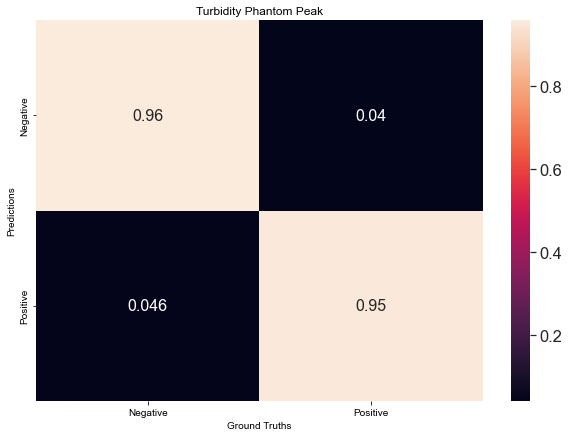

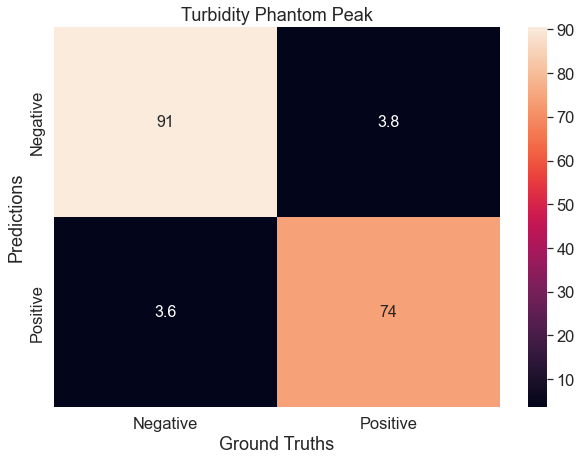

In [5]:
overall_start = datetime.datetime.now()

split = 1

# Iterate through the splits, previous test gets appended to the new train after every iteration
for train_val_indices, test_indices in train_test_split_indices:
    X_train, y_train = [turb_cand[i] for i in train_val_indices], [truths[i] for i in train_val_indices]
    X_test, y_test = [turb_cand[i] for i in test_indices], [truths[i] for i in test_indices]
    
    max_fold_metric = 0 
    max_result = None 
    
    print("Split: ",split)
    
    split_start = datetime.datetime.now()
    
    for iteration in range(iterations):
        
        # Random grid search for hyperparams 
        params = {}
        
        params['x'] = np.random.randint(x_bounds[0], x_bounds[1]+1)
        params['y'] = np.random.randint(y_bounds[0], y_bounds[1]+1)

        temp = np.random.randint(intf_range_1_bounds[0], intf_range_1_bounds[1])
        params['inft_range_1'] = (temp, np.random.randint(temp, intf_range_1_bounds[1]) + 2)
        
        temp = np.random.randint(intf_range_2_bounds[0], intf_range_2_bounds[1])
        params['inft_range_2'] = (temp, np.random.randint(temp, intf_range_2_bounds[1]) + 2)
        
        temp = np.random.randint(intf_range_3_bounds[0], intf_range_3_bounds[1])
        params['inft_range_3'] = (temp, np.random.randint(temp, intf_range_3_bounds[1]) + 2)
        
        params['intf_t1'] = np.random.uniform(intf_threshold_bounds[0], intf_threshold_bounds[1])
        params['intf_t2'] = np.random.uniform(intf_threshold_bounds[0], intf_threshold_bounds[1])
        
        predictions = classify_candidate_peaks(X_train, params)
        
        TP,TN,FP,FN,results = label_positives_negatives(predictions, y_train)
        
        TPR = 0 if TP == FN == 0 else TP/(TP + FN)
        TNR = TN/(TN + FP)
    
        bal_acc = (TPR + TNR)/2 

        f1_score = 0 if TP == FP == FN == 0 else (2 * TP)/((2 * TP) + FP + FN)

        acc = bal_acc
        if iteration and iteration % int(iterations/10) == 0: print(" {}/{} ".format(iteration, iterations), end = "")
        if acc > max_fold_metric: 
            max_fold_metric = acc
            max_result = copy.deepcopy(results)
            best_params = copy.deepcopy(params)
            
    # Test best parameters on testing data 
    test_predictions = classify_candidate_peaks(X_test, best_params)
    TP,TN,FP,FN,results = label_positives_negatives(test_predictions, y_test)
    
    cfmx = confusion_matrix([row[2] for row in y_test],[row[1] for row in test_predictions], labels = ['NPP', 'PP'])
    accumulated_cfmxs[split] = copy.deepcopy(cfmx)
    
    TPR = 0 if TP == FN == 0 else TP/(TP + FN)
    TNR = TN/(TN + FP)
    
    precision = 0 if TP == FP == 0 else TP/(TP + FP)
        
    bal_acc = (TPR + TNR)/2 
        
    f1_score = 0 if TP == FP == FN == 0 else (2 * TP)/((2 * TP) + FP + FN)
    
    print('\nSplit: {}  F1: {:.4f} BA: {:.4f}  Params: {}  TP: {} TN: {} FP: {} FN: {}  Time: {}'.format(split, f1_score, bal_acc, best_params, TP, TN, FP, FN, datetime.datetime.now() - split_start))
    accumulated_test_metrics[split] = {'f1': f1_score, 'ba' : bal_acc, 'tpr': TPR, 'tnr' : TNR, 'precision': precision} # Record test metrics of each split
    accumulated_test_results[split] = copy.deepcopy(results) # Record test results (FP,FN,TP,TN for each datapoint) for each split
    accumulated_best_params[split] = copy.deepcopy(best_params) # Record params uses in testing for each split
    
    split+=1

# Display Resuls 
mean_f1 = 0
mean_ba = 0 
mean_sensitivity = 0
mean_specificity = 0 
mean_precision = 0

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]
    
    mean_f1+=metrics['f1']
    mean_ba+=metrics['ba']
    mean_sensitivity += metrics['tpr']
    mean_specificity += metrics['tnr']
    mean_precision += metrics['precision']

print("Mean Test F1: ", mean_f1/len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba/len(accumulated_test_metrics))
print("Mean Test TPR: ", mean_sensitivity/len(accumulated_test_metrics))
print("Mean Test TNR: ", mean_specificity/len(accumulated_test_metrics))
print("Mean Test Precision: ", mean_precision/len(accumulated_test_metrics))

print("Training time: ", datetime.datetime.now() - overall_start)

# Pickle params from last fold
with open('Anomaly_Detection/Experimental_Results/turb_PP/best_params.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_best_params[num_splits], pck_file)
    pck_file.close()
    
# Pickle results from last fold 
with open('Anomaly_Detection/Experimental_Results/turb_PP/test_results.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_results, pck_file)
    pck_file.close()

# Pickle results from last fold 
with open('Anomaly_Detection/Experimental_Results/turb_PP/test_metrics.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_metrics, pck_file)
    pck_file.close()
    
mean_cfmx = np.zeros((2,2))
for key in accumulated_cfmxs.keys():
    mean_cfmx += accumulated_cfmxs[key]
mean_cfmx = mean_cfmx / num_splits

plt.figure(figsize = (10,7))
plt.title(label = 'Turbidity Phantom Peak')

sn.set(font_scale = 1.5)
sn.heatmap( pd.DataFrame(mean_cfmx.astype('float') / mean_cfmx.sum(axis=1)[:, np.newaxis],index = ['Negative', 'Positive'], columns = ['Negative','Positive']), annot = True, annot_kws ={"size": 16})
plt.xlabel('Ground Truths')
plt.ylabel('Predictions')
plt.show()

plt.figure(figsize = (10,7))
plt.title(label = 'Turbidity Phantom Peak')

sn.set(font_scale = 1.5)
sn.heatmap( pd.DataFrame(mean_cfmx,index = ['Negative', 'Positive'], columns = ['Negative','Positive']), annot = True, annot_kws ={"size": 16})
plt.xlabel('Ground Truths')
plt.ylabel('Predictions')
plt.show()

### Plot results to look for inconsistencies

In [6]:
# Get stage rises
s_indices = detect_stage_rises(stage_data[:,1])

fDOM_cand_params = {'prom' : [4,None],
                    'width': [None, 2],
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}


turb_cand_params = {'prom' : [6,None],
                    'width': [None, 2],
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}

# Get fDOM and turb candiate peaks
fDOM_peaks, fDOM_props = get_candidates(fDOM_raw_data, fDOM_cand_params)
turb_peaks, turb_props = get_candidates(turb_data, turb_cand_params)

# Remove peaks that occur during a flat plateau 
turb_flat_plat = detect_flat_plat(turb_data, 100, 40)
turb_flat_plat_indxs = []
for i in range(turb_flat_plat.shape[0]):
    if turb_flat_plat[i] == 1:
        turb_flat_plat_indxs.append(i)

take_indices = []
for i,peak in enumerate(turb_peaks):
    if peak not in turb_flat_plat_indxs:
        take_indices.append(i)

turb_peaks = np.take(turb_peaks, take_indices)
for key in turb_props:
    turb_props[key] = np.take(turb_props[key], take_indices)


fDOM_events = []
fDOM_lb = []
fDOM_rb = []

for i,peak in enumerate(fDOM_peaks):
            fDOM_events.append(np.array((fDOM_raw_data[peak])))
            fDOM_lb.append(fDOM_raw_data[math.floor(fDOM_props['left_ips'][i]),0])
            fDOM_rb.append(fDOM_raw_data[math.ceil(fDOM_props['right_ips'][i]),0])
            
fDOM_lb = list(set(fDOM_lb))
fDOM_lb.sort()
fDOM_rb = list(set(fDOM_rb))
fDOM_rb.sort()

turb_events = []
turb_lb = []
turb_rb = []
for i,peak in enumerate(turb_peaks):
            turb_events.append(np.array((turb_data[peak])))
            turb_lb.append(turb_data[math.floor(turb_props['left_ips'][i]),0])
            turb_rb.append(turb_data[math.ceil(turb_props['right_ips'][i]),0])
            
turb_lb = list(set(turb_lb))
turb_lb.sort()
turb_rb = list(set(turb_rb))
turb_rb.sort()            

fDOM_merged = dp.merge_data(fDOM_raw_data, fDOM_events, 'f_opp', '')
turb_merged = dp.merge_data(turb_data, turb_events, 't_opp', '')

fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_lb, 'left_base')
fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_rb, 'right_base')

turb_merged = dp.merge_additional_data(turb_merged, turb_lb, 'left_base')
turb_merged = dp.merge_additional_data(turb_merged, turb_rb, 'right_base')


stage_edge_data = dp.stage_rises_to_data(s_indices, stage_data)
stage_data_merged = dp.merge_data(stage_data, stage_edge_data, 'rise','')

In [8]:
dm.write_data_to_trainset(fDOM_merged,
                          stage_data_merged,
                          turb_merged,
                          'Data/temp_plotting/pred_turb_pp_0k-100k.csv',
                          True,
                          True,
                          0,
                          100000)